## Prediction of Housing Prices in US
| Name                  | Admin No. | Class          |
| --------------------- | --------- | -------------- |
| Ernest Ng Sheng Kang  | P2222668  | DAAA/FT/2B/06  |
### Problem Statement
> Develop a Regression Model to Predict the housing price in US based on various factors such as city, house area, No. of bedrooms and toilets, renovation status, etc


In [42]:
#comment out if already installed
! pip install imblearn

## Importing Libraries and Data

In [43]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
from warnings import filterwarnings
import re
import scipy.stats as ss
import plotly.express as px

# SKLEARN Libraries
# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from mlxtend.preprocessing import DenseTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import TransformedTargetRegressor

# Model Selection
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer

# Models
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import HuberRegressor,TheilSenRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

# Pickle Library = Saving Models
import pickle


In [84]:
df = pd.read_csv('./datasets/housing_dataset.csv')
display(df)

,House ID,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,0,Chicago,742.0,4,2,3,furnished,1330000
1,1,Denver,896.0,4,4,4,furnished,1225000
2,2,Chicago,996.0,3,2,2,semi-furnished,1225000
3,3,Seattle,750.0,4,2,2,furnished,1221500
4,4,New York,742.0,4,1,2,furnished,1141000
...,...,...,...,...,...,...,...,...
540,540,Seattle,300.0,2,1,1,unfurnished,182000
541,541,New York,240.0,3,1,1,semi-furnished,176715
542,542,Boston,362.0,2,1,1,unfurnished,175000
543,543,Seattle,291.0,3,1,1,furnished,175000


### Defining Utility Function

In [45]:

def create_results_dataframe(models, X_train, y_train,X_test ,y_test,cv, steps,step):
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    resultsdf = pd.DataFrame()

    for name, model in models.items():
        steps[step] = (name, model)
        pipeline = Pipeline(steps=steps)
        cv_scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True)
        r2_train = np.mean(cv_scores['train_r2'])
        r2_test = np.mean(cv_scores['test_r2'])
        mse_train = np.mean(cv_scores['train_neg_mean_squared_error']) * -1
        mse_test = np.mean(cv_scores['test_neg_mean_squared_error']) * -1
        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)

        # Calculate MAPE using all predicted and actual values
        pipeline.fit(X_train, y_train)
        y_pred_train = pipeline.predict(X_train)
        mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
        y_pred_test = pipeline.predict(X_test)
        mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

        model_scores = pd.Series({'Model': name, 'R-squared (Train)': r2_train, 'R-squared (Test)': r2_test,
                                  'RMSE (Train)': rmse_train, 'RMSE (Test)': rmse_test,
                                  'MAPE (Train)': mape_train, 'MAPE (Test)': mape_test})
        resultsdf = resultsdf.append(model_scores, ignore_index=True)

    # Sort the DataFrame based on R-squared (Test)
    resultsdf_sorted = resultsdf.sort_values(by='R-squared (Test)', ascending=False)

    resultsdf_styled = resultsdf_sorted.style.apply(lambda x: ['background-color: green']*len(x) if x.name in resultsdf_sorted.index[:3] else ['background-color: None']*len(x), axis=1)
    return resultsdf_styled


def plot_learning_curve(model, X_train, y_train, cv, scoring_metrics, train_sizes,steps,step, model_name="Model"):
    fig, axes = plt.subplots(1, len(scoring_metrics), figsize=(20, 8))
    axes = axes.ravel()

    for i, metric in enumerate(scoring_metrics):
        steps[step] = (str(model), model)
        pipeline = Pipeline(steps=steps)
        train_sizes_abs, train_scores, val_scores = learning_curve(pipeline, X_train, y_train, train_sizes=train_sizes, cv=cv, scoring=metric)

        train_scores_mean = -np.mean(train_scores, axis=1)
        val_scores_mean = -np.mean(val_scores, axis=1)

        ax = axes[i]
        ax.plot(train_sizes_abs, train_scores_mean, label='Train')
        ax.plot(train_sizes_abs, val_scores_mean, label='Validation')
        ax.set_xlabel("Training Set Size")
        ax.set_ylabel(metric)
        ax.legend(loc="best")
        ax.set_title(f"Learning Curve: {model_name} - {metric}")

        ax.invert_yaxis()

    # Hide empty subplots
    for j in range(len(scoring_metrics), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    

def plot_prediction_error_plot(model, X_train, y_train, X_test, y_test, steps, step, ax=None):
    # Create the pipeline
    steps[step] = (str(model), model)
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    # rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Plot the prediction error
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(y_test, y_pred, c="red", marker="o")
    p1 = max(max(y_pred), max(y_test))
    p2 = min(min(y_pred), min(y_test))
    ax.plot([p1, p2], [p1, p2], "b--", label="Identity")
    a, b = np.polyfit(y_test, y_pred, 1)
    ax.plot(y_test, a * y_test + b, "g-", label="Best Fit")
    ax.legend()
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predictions")
    ax.set_title(f"Prediction Error Plot using {model}")
    # print(f"{model}'s R2: {r2_score(y_test, y_pred)}, RMSE: {rmse}, MAPE: {mape}")
    return ax


def plot_residuals(model, X_train, y_train, X_test, y_test, steps, step, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Create the pipeline
    steps[step] = (str(model), model)
    pipeline = Pipeline(steps=steps)
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    residuals = y_test - y_pred

    # Calculate R2, RMSE, and MAPE
    # r2 = r2_score(y_test, y_pred)
    # rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    # print(f"{model}'s R2: {r2}, RMSE: {rmse}, MAPE: {mape}")

    # Plot the residuals
    ax.scatter(y_pred, residuals, color='blue', alpha=0.5)
    ax.axhline(y=0, color='red', linestyle='--')

    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_title(f'Residual Plot')

    if ax is None:
        plt.show()
    else:
        return ax


## Evaluating Data

 - __House ID__: Unique house identifier ranging from 0 to 544
 - __City: Which__ city the house is located
 - __House Area__: Size of the house in square meters
 - __No. of Bedrooms__: How many bedrooms in the house
 - __No. of Toilets__: How many toilets in the house
 - __Stories__: The number of stories in the house
 - __Renovation Status__: How well the house is renovated
 - __Price__: The price of the house in US dollars

### Data Exploration

##### Descriptive Statistics

In [46]:
housingDf = df.copy()
housingDf.shape

(545, 8)

In [47]:
housingDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   House ID           545 non-null    int64  
 1   City               545 non-null    object 
 2   House Area (sqm)   545 non-null    float64
 3   No. of Bedrooms    545 non-null    int64  
 4   No. of Toilets     545 non-null    int64  
 5   Stories            545 non-null    int64  
 6   Renovation Status  545 non-null    object 
 7   Price ($)          545 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 34.2+ KB


- The dataset contains 545 observations (rows) and 8 columns.
- The data types of the columns include int64, float64, and object (representing categorical variables).
- The dataset does not have any missing values (non-null count indicates that all columns have 545 non-null entries).

In [48]:
descriptive_stats = housingDf.describe(include="all").T
descriptive_stats["Proportion of Most Frequent Value"] = (
    descriptive_stats["freq"] / len(housingDf) * 100
)
descriptive_stats.sort_values("Proportion of Most Frequent Value", ascending=False)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,Proportion of Most Frequent Value
Renovation Status,545,3,semi-furnished,227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.651376
City,545,5,New York,158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.990826
House ID,545.0,NaN,NaN,NaN,272.0,157.47222,0.0,136.0,272.0,408.0,544.0,NaN
House Area (sqm),545.0,NaN,NaN,NaN,515.054128,217.014102,165.0,360.0,460.0,636.0,1620.0,NaN
No. of Bedrooms,545.0,NaN,NaN,NaN,2.965138,0.738064,1.0,2.0,3.0,3.0,6.0,NaN
No. of Toilets,545.0,NaN,NaN,NaN,1.286239,0.50247,1.0,1.0,1.0,2.0,4.0,NaN
Stories,545.0,NaN,NaN,NaN,1.805505,0.867492,1.0,1.0,2.0,2.0,4.0,NaN
Price ($),545.0,NaN,NaN,NaN,476672.924771,187043.961566,175000.0,343000.0,434000.0,574000.0,1330000.0,NaN


##### Check for Missing Values

In [49]:
missing_values = housingDf.isnull().sum()
print(missing_values)

House ID             0
City                 0
House Area (sqm)     0
No. of Bedrooms      0
No. of Toilets       0
Stories              0
Renovation Status    0
Price ($)            0
dtype: int64


## Visualizing our Data


### Univariate Analysis
#### Target Variable

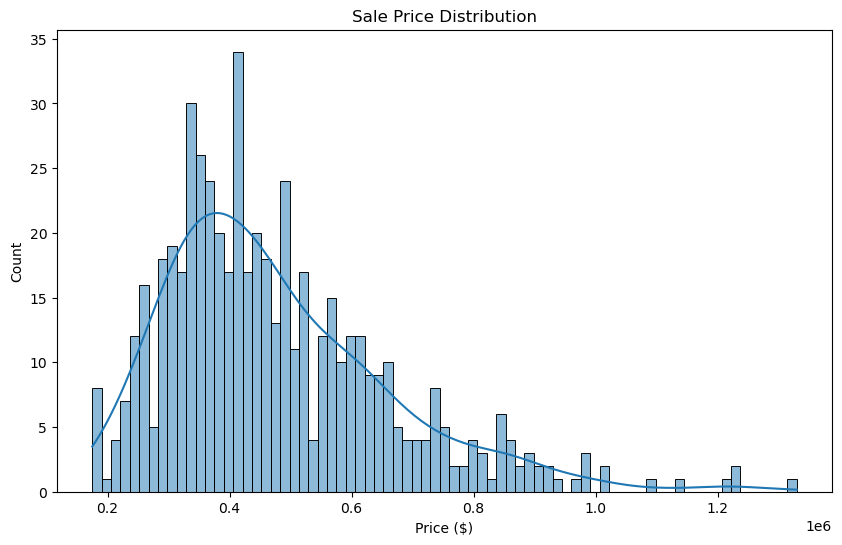

In [50]:
plt.figure(figsize=(10, 6))
sns.histplot(data=housingDf, x="Price ($)", kde=True,bins=75)
plt.title("Sale Price Distribution")
plt.xlabel("Price ($)")
plt.ylabel("Count")

plt.show()

We can see that the Housing Price is positively skewed. Most house are under 700k, but some houses cost more than a million. In such cases, the mean and standard deviation alone may not accurately capture the distribution of house prices. The presence of high-priced houses can significantly affect these descriptive statistics and potentially skew the distribution.

#### Quantitative Features

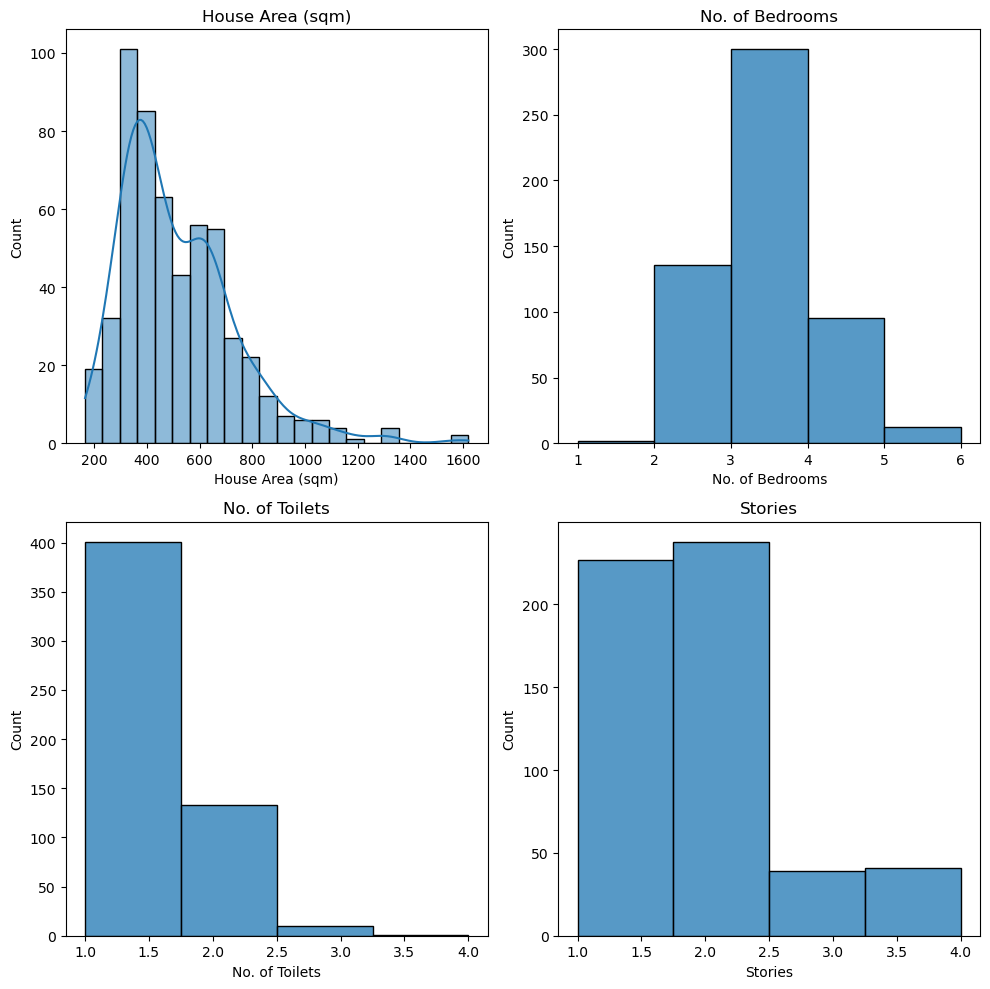

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot House Area (sqm)
sns.histplot(housingDf['House Area (sqm)'], ax=axes[0, 0], kde=True)
axes[0, 0].set_title('House Area (sqm)')

# Plot No. of Bedrooms
sns.histplot(housingDf['No. of Bedrooms'], ax=axes[0, 1],bins=5)
axes[0, 1].set_title('No. of Bedrooms')

# Plot No. of Toilets
sns.histplot(housingDf['No. of Toilets'], ax=axes[1, 0],bins=4)
axes[1, 0].set_title('No. of Toilets')

# Plot Stories
sns.histplot(housingDf['Stories'], ax=axes[1, 1],bins=4)
axes[1, 1].set_title('Stories')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

We can see that in the Histograms that:
- House Area is positively skewed, like Housing price
- The number of bedrooms follow a normal distribution
- The amount of toliets are slightly skewed to the right

#### Catergorical Features

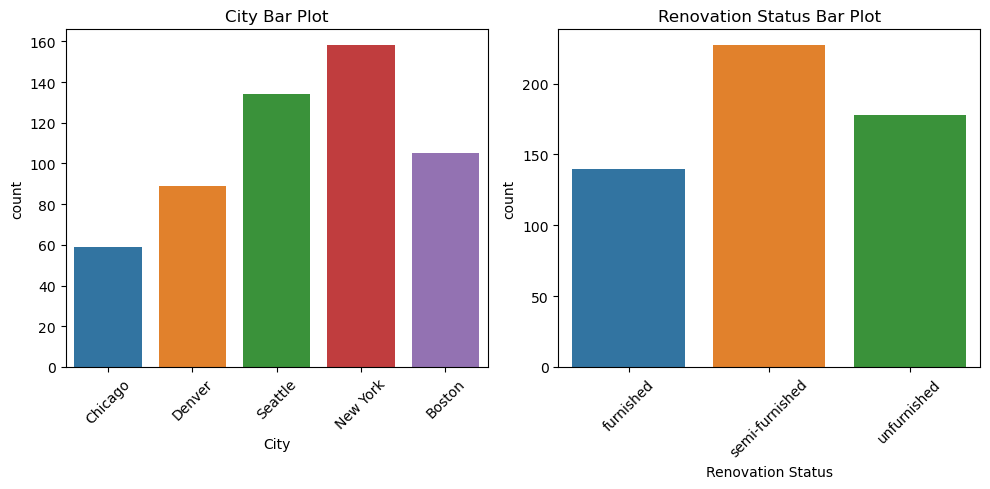

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot bar plot for "City"
sns.countplot(data=housingDf, x="City", ax=axs[0])
axs[0].set_title("City Bar Plot")

# Plot bar plot for "Renovation Status"
sns.countplot(data=housingDf, x="Renovation Status", ax=axs[1])
axs[1].set_title("Renovation Status Bar Plot")

# Rotate x-axis labels if needed
for ax in axs:
    ax.tick_params(axis='x', rotation=45)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


We can see that:
- New York has the highest number of houses compared to other cities in the dataset. This suggests that the real estate market in New York is more active or that data collection focused more on properties in New York.
- The majority of houses in the dataset are categorized as "semi-furnished." This indicates that a significant portion of the houses have some furniture or basic furnishings included, but not all necessary items for comfortable living.

### Bivariate Analysis
We will explore and examine the relationships among the different variables.

#### Pearson Correlation
$$
r = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2} \sqrt{\sum (y_i - \bar{y})^2}}
$$
Pearson correlation is used to measure the linear relationship between two continuous variables.

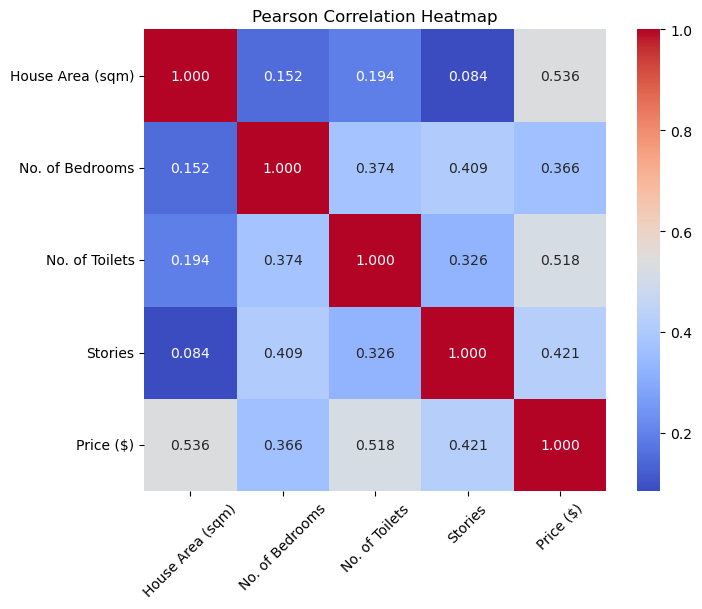

In [53]:
# Select the columns for correlation
columns = ['House Area (sqm)', 'No. of Bedrooms', 'No. of Toilets', 'Stories', 'Price ($)']

# Compute the Pearson correlation matrix
corr_matrix = df[columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f", square=True)

# Customize the plot
plt.title("Pearson Correlation Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show the plot
plt.show()

Observtions:
 - None of the features are majorly correlated with each other(>0.5),indicating that there is no significant linear relationship or dependency among the features.

This implies that the variables in the dataset are relatively independent of each other and do not exhibit strong pairwise relationships. It also suggests that the features capture distinct aspects or characteristics of the data, without redundancy or high collinearity.

#### Cateorgical Feature

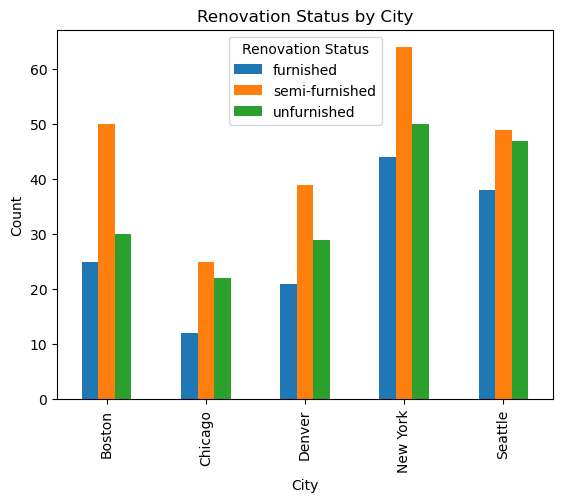

In [54]:
# Group the data by 'City' and 'Renovation Status' and calculate the counts
grouped = housingDf.groupby(['City', 'Renovation Status']).size().unstack()

# Create the grouped bar chart
grouped.plot(kind='bar')

# Add labels and title
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Renovation Status by City')

# Show the chart
plt.show()

We can see from the grouped bar chart that:
- Most houses are semi-furnished, suggesting that they may contain essential furniture and basic amenities.

## Data Processing

#### DataSet With all the required features and target label

In [55]:
housingDf = housingDf.drop('House ID', axis=1)
housingDf

,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,Chicago,742.0,4,2,3,furnished,1330000
1,Denver,896.0,4,4,4,furnished,1225000
2,Chicago,996.0,3,2,2,semi-furnished,1225000
3,Seattle,750.0,4,2,2,furnished,1221500
4,New York,742.0,4,1,2,furnished,1141000
...,...,...,...,...,...,...,...
540,Seattle,300.0,2,1,1,unfurnished,182000
541,New York,240.0,3,1,1,semi-furnished,176715
542,Boston,362.0,2,1,1,unfurnished,175000
543,Seattle,291.0,3,1,1,furnished,175000


### Feature Engineering
**Did you process the features in any way?**

- We will be adding a new feature called Total Room Count, it is created by by summing the number of bedrooms and the number of toilets.
- This aims to help the model to better capture the underlying patterns and relationships in the data.

In [56]:
housingDf['Total Room Count'] = housingDf['No. of Bedrooms'] + housingDf['No. of Toilets']

#### Finding and Removing Extreme outliers

In [57]:
def mark_extreme_outlier(df, var):
  col = df[var].apply(np.log)
  Q3 = col.quantile(0.75)
  Q1 = col.quantile(0.25)
  IQR = Q3 - Q1
  UpperFence = Q3 + 3 * IQR
  LowerFence = Q1 - 3 * IQR
  mask = (col > UpperFence) | (col < LowerFence)
  return mask.values

marked_outliers = [mark_extreme_outlier(housingDf, col) for col in ("House Area (sqm)", "Price ($)")]
columns = ("House Area (sqm)", "Price ($)")
for i in range(len(marked_outliers)):
    print(columns[i] + " Total Outliers: " + str(marked_outliers[i].sum()))

House Area (sqm) Total Outliers: 0
Price ($) Total Outliers: 0


#### Encoding Categorical 

In [58]:
categorical_columns = ['City', 'Renovation Status']

# Use pd.get_dummies() to encode the categorical columns
encoded_df = pd.get_dummies(housingDf, columns=categorical_columns)
encoded_df

,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Price ($),Total Room Count,City_Boston,City_Chicago,City_Denver,City_New York,City_Seattle,Renovation Status_furnished,Renovation Status_semi-furnished,Renovation Status_unfurnished
0,742.0,4,2,3,1330000,6,0,1,0,0,0,1,0,0
1,896.0,4,4,4,1225000,8,0,0,1,0,0,1,0,0
2,996.0,3,2,2,1225000,5,0,1,0,0,0,0,1,0
3,750.0,4,2,2,1221500,6,0,0,0,0,1,1,0,0
4,742.0,4,1,2,1141000,5,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,300.0,2,1,1,182000,3,0,0,0,0,1,0,0,1
541,240.0,3,1,1,176715,4,0,0,0,1,0,0,1,0
542,362.0,2,1,1,175000,3,1,0,0,0,0,0,0,1
543,291.0,3,1,1,175000,4,0,0,0,0,1,1,0,0


#### Separate Target & Features

In [59]:
X = encoded_df.drop(columns=['Price ($)'])
y = encoded_df['Price ($)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

#### Standard Scaling

In [60]:
scaled_df = encoded_df.copy()

# Select the columns to be scaled
# columns_to_scale = ['House Area (sqm)', 'No. of Bedrooms', 'No. of Toilets', 'Stories']
columns_to_scale = ['House Area (sqm)','No. of Bedrooms','No. of Toilets','Stories','Total Room Count']

# Create a StandardScaler object
scaler = StandardScaler()

# Apply standard scaling to the selected columns
scaled_data = scaler.fit_transform(scaled_df[columns_to_scale])

# Create a new DataFrame with the scaled data
scaled_columns_df = pd.DataFrame(scaled_data, columns=columns_to_scale)

# Update the original DataFrame with the scaled columns
scaled_df[columns_to_scale] = scaled_columns_df

# Print the updated DataFrame with scaled columns
scaled_df

,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Price ($),Total Room Count,City_Boston,City_Chicago,City_Denver,City_New York,City_Seattle,Renovation Status_furnished,Renovation Status_semi-furnished,Renovation Status_unfurnished
0,1.046726,1.403419,1.421812,1.378217,1330000,1.688416,0,1,0,0,0,1,0,0
1,1.757010,1.403419,5.405809,2.532024,1225000,3.619554,0,0,1,0,0,1,0,0
2,2.218232,0.047278,1.421812,0.224410,1225000,0.722848,0,1,0,0,0,0,1,0
3,1.083624,1.403419,1.421812,0.224410,1221500,1.688416,0,0,0,0,1,1,0,0
4,1.046726,1.403419,-0.570187,0.224410,1141000,0.722848,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,-0.991879,-1.308863,-0.570187,-0.929397,182000,-1.208290,0,0,0,0,1,0,0,1
541,-1.268613,0.047278,-0.570187,-0.929397,176715,-0.242721,0,0,0,1,0,0,1,0
542,-0.705921,-1.308863,-0.570187,-0.929397,175000,-1.208290,1,0,0,0,0,0,0,1
543,-1.033389,0.047278,-0.570187,-0.929397,175000,-0.242721,0,0,0,0,1,1,0,0


#### Checking for multicolinearity in the data
So why do we check for multicolinearity in the data? Checking for multicollinearity in data is essential due to several reasons. Firstly, it affects the stability and reliability of coefficient estimates, making them susceptible to small changes in data or model specifications. Secondly, multicollinearity inflates standard errors, reducing the precision and making it challenging to detect significant relationships between features and the target variable.

So we use Variance Inflation Factor to check the multicolinearity in the continouse features:
$$
    VIF_i = \frac {1}{1 - R_i^2}
$$

In [61]:
predictors = encoded_df[['House Area (sqm)', 'No. of Bedrooms', 'No. of Toilets', 'Stories']]

# Calculate the correlation matrix for the predictor variables
corr_matrix = predictors.corr()

# Calculate the inverse of the correlation matrix
inv_corr_matrix = np.linalg.inv(corr_matrix)

# Calculate the VIF values
vif = pd.DataFrame()
vif["Variable"] = predictors.columns
vif["VIF"] = np.diagonal(inv_corr_matrix).round(3)  # Round the VIF values to 5 significant figures

# Display the VIF values
print(vif)

           Variable    VIF
0  House Area (sqm)  1.047
1   No. of Bedrooms  1.311
2    No. of Toilets  1.241
3           Stories  1.253


We can see that all predictor variables have VIF values close to 1, indicating a low level of multicollinearity. This suggests that there is minimal correlation between these variables, and they can be considered as independent predictors in the regression model.And thus we dont need to use regularization techniques such as Ridge Regression or Lasso Regression.

### Feature Transformation


In [62]:
# columns_to_transform = ['House Area (sqm)', 'No. of Toilets', 'Stories']

columns_to_transform = ['No. of Toilets','Stories','House Area (sqm)','Total Room Count']
transformed_df = scaled_df.copy()


# Create a QuantileTransformer object
power_transformer  = PowerTransformer()

# Apply QuantileTransformer to the selected columns
transformed_df[columns_to_transform] = power_transformer.fit_transform(scaled_df[columns_to_transform])

# Print the transformed DataFrame
transformed_df

,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Price ($),Total Room Count,City_Boston,City_Chicago,City_Denver,City_New York,City_Seattle,Renovation Status_furnished,Renovation Status_semi-furnished,Renovation Status_unfurnished
0,1.128400,1.403419,1.657170,1.333728,1330000,1.519517,0,1,0,0,0,1,0,0
1,1.554443,1.403419,1.841904,1.912994,1225000,2.618185,0,0,1,0,0,1,0,0
2,1.791033,0.047278,1.657170,0.489374,1225000,0.823573,0,1,0,0,0,0,1,0
3,1.152901,1.403419,1.657170,0.489374,1221500,1.519517,0,0,0,0,1,1,0,0
4,1.128400,1.403419,-0.599130,0.489374,1141000,0.823573,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,-1.202056,-1.308863,-0.599130,-1.087750,182000,-1.399552,0,0,0,0,1,0,0,1
541,-1.721930,0.047278,-0.599130,-1.087750,176715,-0.100130,0,0,0,1,0,0,1,0
542,-0.715739,-1.308863,-0.599130,-1.087750,175000,-1.399552,1,0,0,0,0,0,0,1
543,-1.277000,0.047278,-0.599130,-1.087750,175000,-0.100130,0,0,0,0,1,1,0,0


## Selecting our model

### Evaluation Metrics we will be using
- **R Square (R²):**
$$
R² = 1 - \frac{RSS}{TSS}
$$
R² measures the proportion of the variance in the target variable that can be explained by the regression model. With 1 being the perfect fit.
RSS is the sum of squares of residuals while TSS is the total sum of squares
- **Mean Squared Error (MSE):**
$$
MSE = \frac{1}{N} \sum (y_i - \hat{y_i})^2
$$
MSE measures the average squared difference between the predicted and actual values. It penalizes larger errors more heavily than smaller errors, as the differences are squared. Lower values indicate better performance
- **Root Mean Squared Error (RMSE):**
$$
RMSE = \sqrt{MSE}
$$
RMSE is the square root of MSE.It is more commonly used than MSE as it has smaller values and is easier to interpret
- **Mean Absolute Error (MAE):**
$$
MAE = \frac{1}{N} \sum |y_i - \hat{y_i}
$$
MAE measures the average absolute difference between the predicted and actual values. MAE is less sensitive to outliers compared to MSE and RMSE since it does not square the differences.
- **Mean Absolute Percentage Error (MAPE):**
$$
MAPE = \frac{1}{N} \sum \left|\frac{y_i - \hat{y_i}}{y_i}\right| \times 100
$$
MAPE improves on MAE by expressing the error as a percentage of the actual value. This allows for a more better understanding of the model's performance


### Pipeline

In [63]:
featurestoscale = [
    "House Area (sqm)","No. of Bedrooms","No. of Toilets","Stories","Total Room Count"
]

Scaler = Pipeline(
    steps=[("Scaler", StandardScaler())]
)
Transformer = Pipeline(
    steps=[("Transformer", PowerTransformer())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("Scaler", Scaler, featurestoscale),
        ("Transformer", Transformer, featurestoscale),
    ]
)

steps = [
    ('preprocessing', preprocessor),
    ('model'),
]

step = len(steps) - 1

In [64]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Huber Regressor": HuberRegressor(),
    "Theil-Sen Regressor": TheilSenRegressor(),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors Regressor": KNeighborsRegressor(),
    "Gaussian Process Regressor": GaussianProcessRegressor(),
    'KernelRidge': KernelRidge(),
    'HistGradientBoostingRegressor': HistGradientBoostingRegressor(),
}

In [65]:
filterwarnings('ignore')

cv = KFold(n_splits=10, shuffle=True, random_state=1)
results = create_results_dataframe(models, X_train, y_train, X_test,y_test,cv, steps,step)
results

,Model,R-squared (Train),R-squared (Test),RMSE (Train),RMSE (Test),MAPE (Train),MAPE (Test)
7,Huber Regressor,0.544216,0.515885,128314.588417,130172.242570,20.552467,17.820746
1,Ridge Regression,0.555041,0.513261,126780.547019,129710.169265,21.269670,18.417593
2,Lasso Regression,0.556244,0.511045,126608.748355,129974.194670,21.163988,18.184763
0,Linear Regression,0.556346,0.510105,126594.096622,130090.709811,21.143601,18.252882
3,ElasticNet Regression,0.530591,0.501695,130211.380450,131616.254604,22.003232,17.995952
8,Theil-Sen Regressor,0.525839,0.497521,130880.431829,133222.960180,20.639864,17.999631
13,HistGradientBoostingRegressor,0.732566,0.460114,98273.674804,134854.712029,16.392928,21.196948
6,Gradient Boosting Regressor,0.798573,0.456331,85279.851212,136206.521094,15.991779,19.717675
10,K-Nearest Neighbors Regressor,0.666123,0.440653,109807.683552,138952.844917,17.749543,19.138442
5,Random Forest Regressor,0.907999,0.414792,57632.537964,141590.089290,9.585669,22.139397


We can see that Huber Regressor, Ridge and Lasso have the best scores overall
 - MSE and MAE are not used to prevent clutering up the screen and thus we use RMSE and MAPE for easier interpretation

Learning curves may vary
 - refer to the powerpoint for learning curve i did the anaylsis about

#### Huber Regressor Learning Curve

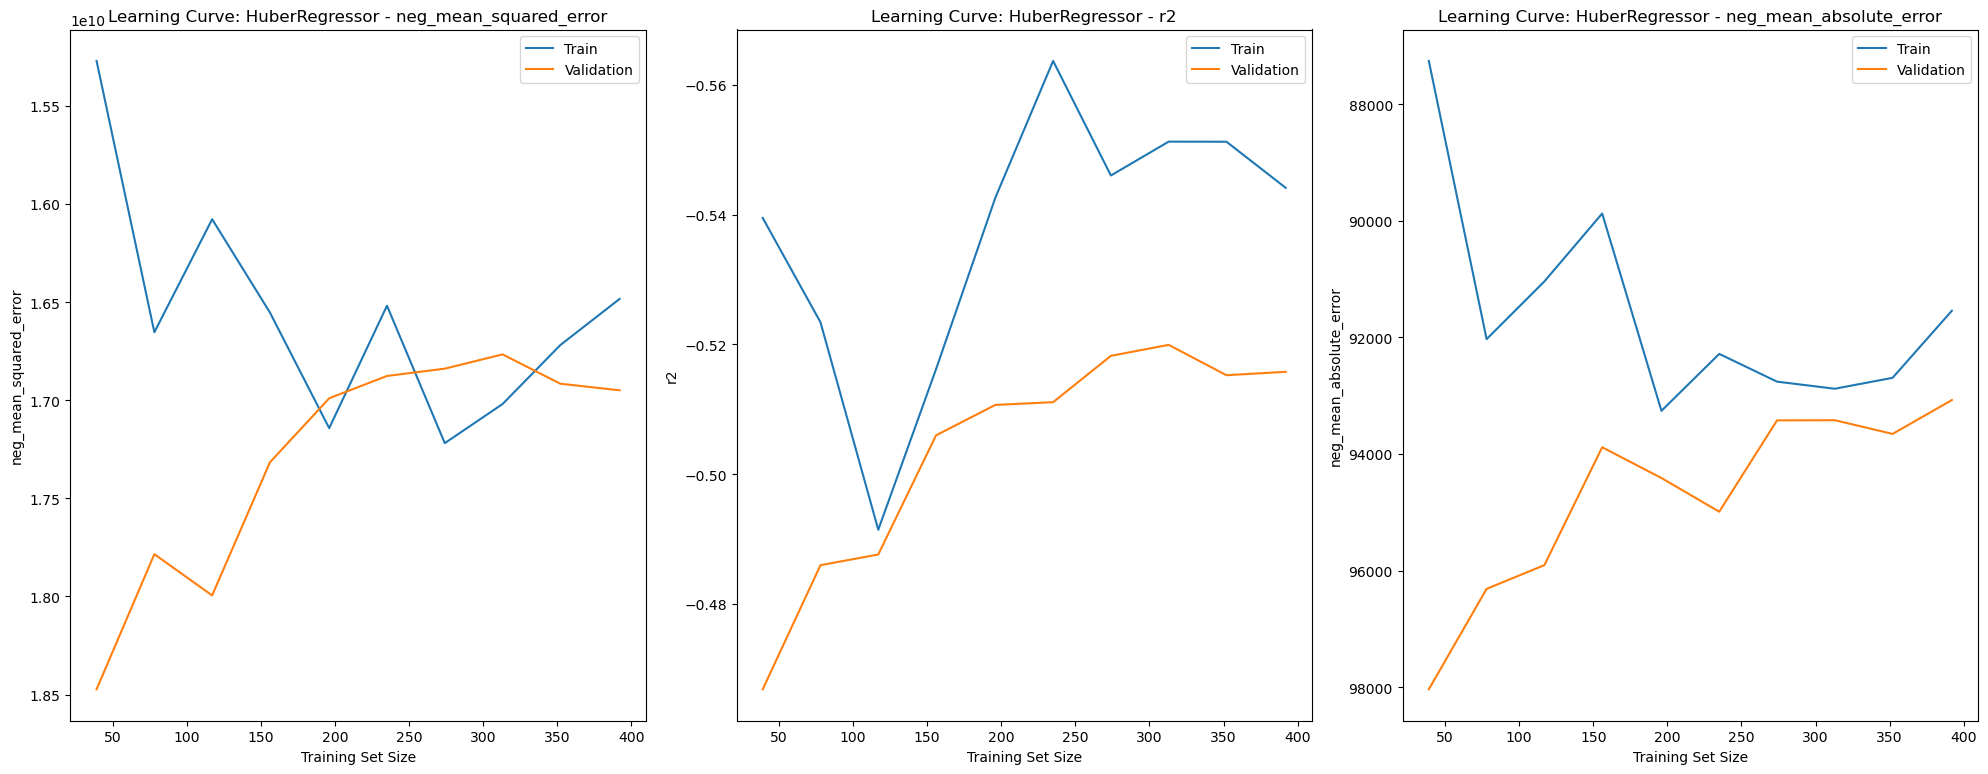

In [66]:
scoring_metrics = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']
train_sizes = np.linspace(0.1, 1.0, 10)

#train and validation curves are flipped as the lower the scoring metric, the better the model for mse and mae
plot_learning_curve(HuberRegressor(), X_train, y_train, cv, scoring_metrics, train_sizes, steps,step,model_name="HuberRegressor")

The Huber Regressor Learning curve has:
- High bias
- High variance

#### Ridge Learning Curve

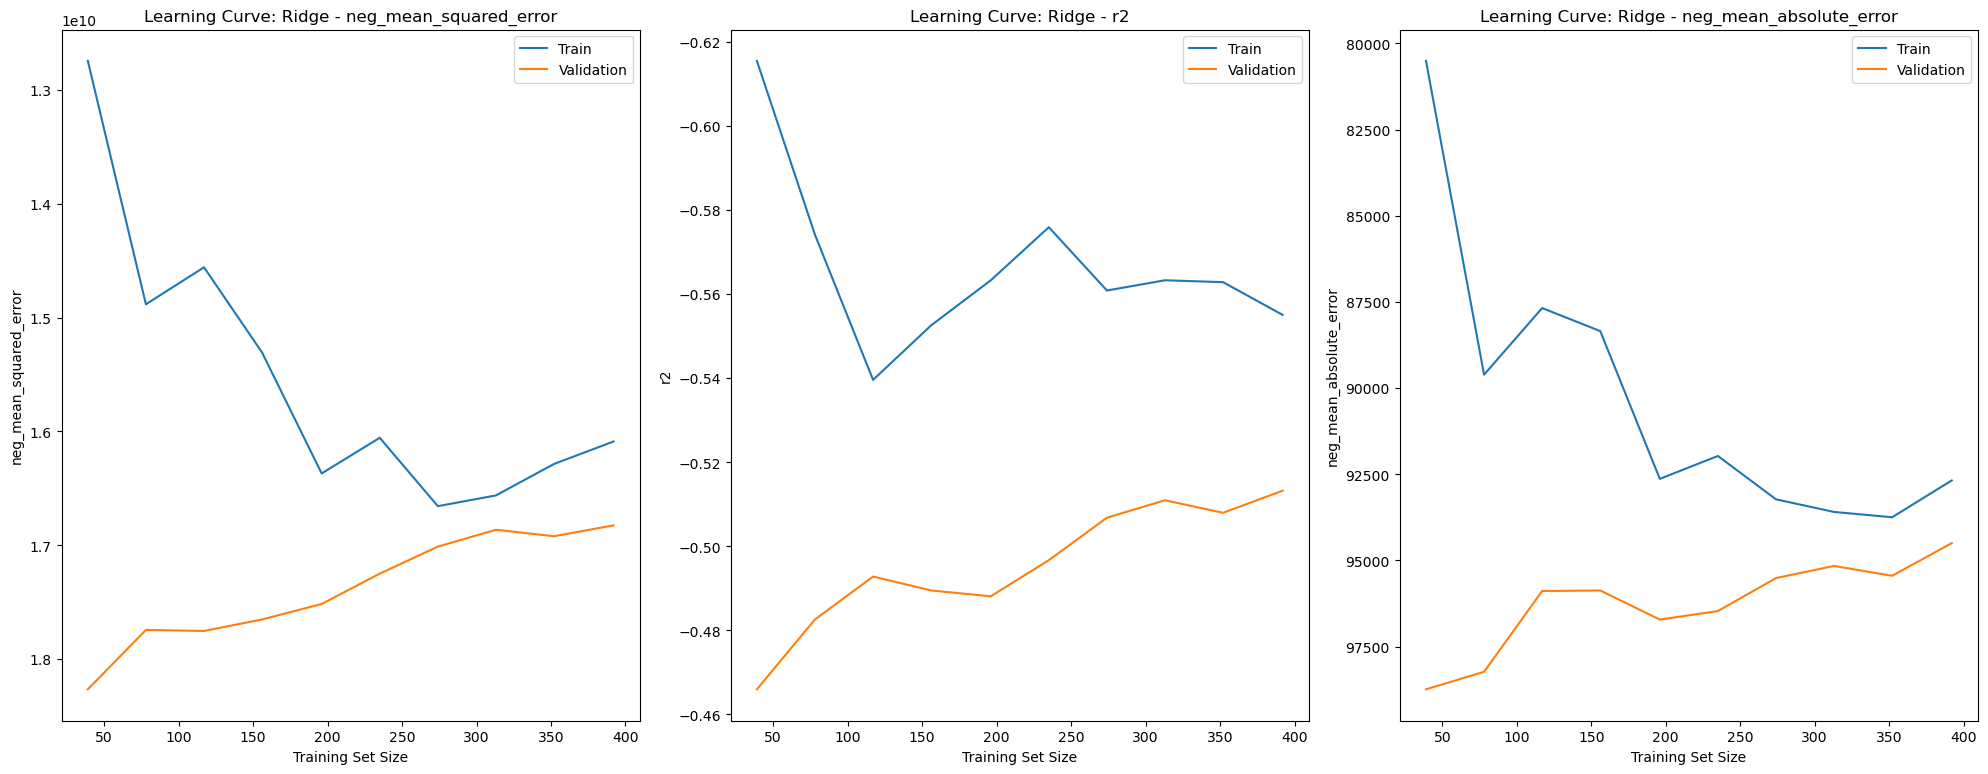

In [67]:
plot_learning_curve(Ridge(), X_train, y_train, cv, scoring_metrics, train_sizes, steps,step,model_name="Ridge")

The Ridge Learning curve has:
- Higher bias
- High variance

#### Lasso Learning Curve

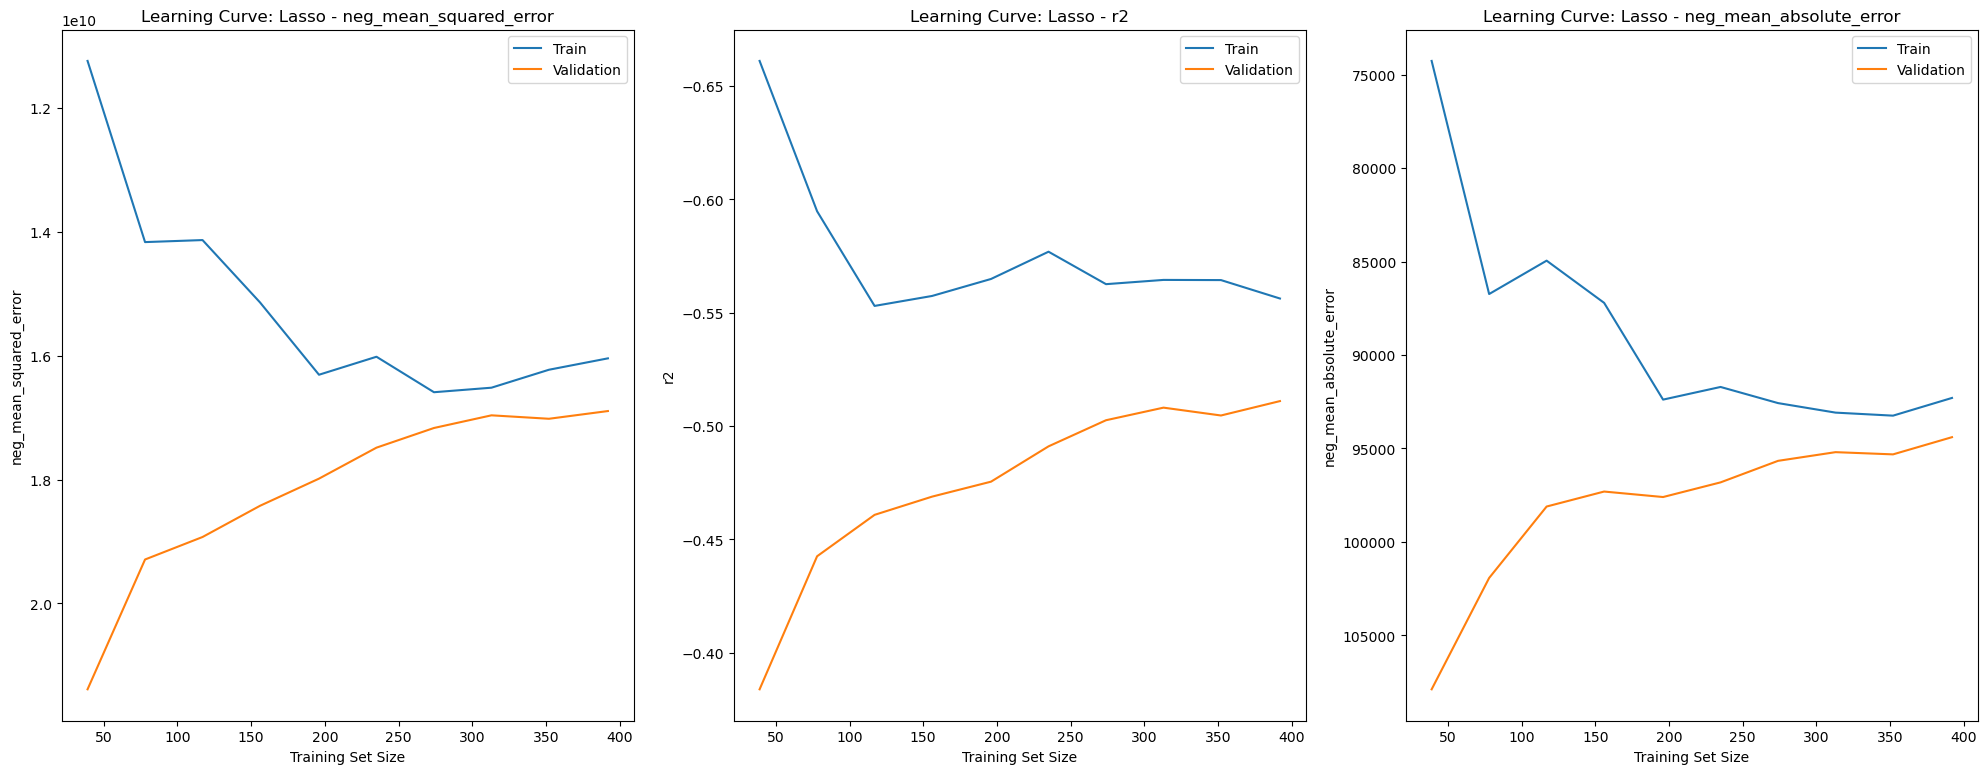

In [68]:
plot_learning_curve(Lasso(), X_train, y_train, cv, scoring_metrics, train_sizes,steps,step, model_name="Lasso")

The Lasso Learning curve has:
- Moderate bias
- Moderate variance

We can see that:
- Learning curves of Lasso and Huber Regressor have a lower variance as compare to Ridge for all 3 scoring metrics. Thus Ridge maybe more prone to overfitting 
- Ridge has quite high bias for its MSE & MAE learning curves, this leads to Ridge being more prone to underfitting and makes strong assumptions that do not capture the underlying patterns in the data.
    - This is a likely case for Ridge as it is both overfitting for R2 and underfitting for MSE and MAE
- The bias of the learning curves for Lasso and Huber Regressor are quite low for the MSE ans MAE graphs and moderate bias with R2.

#### Baseline model

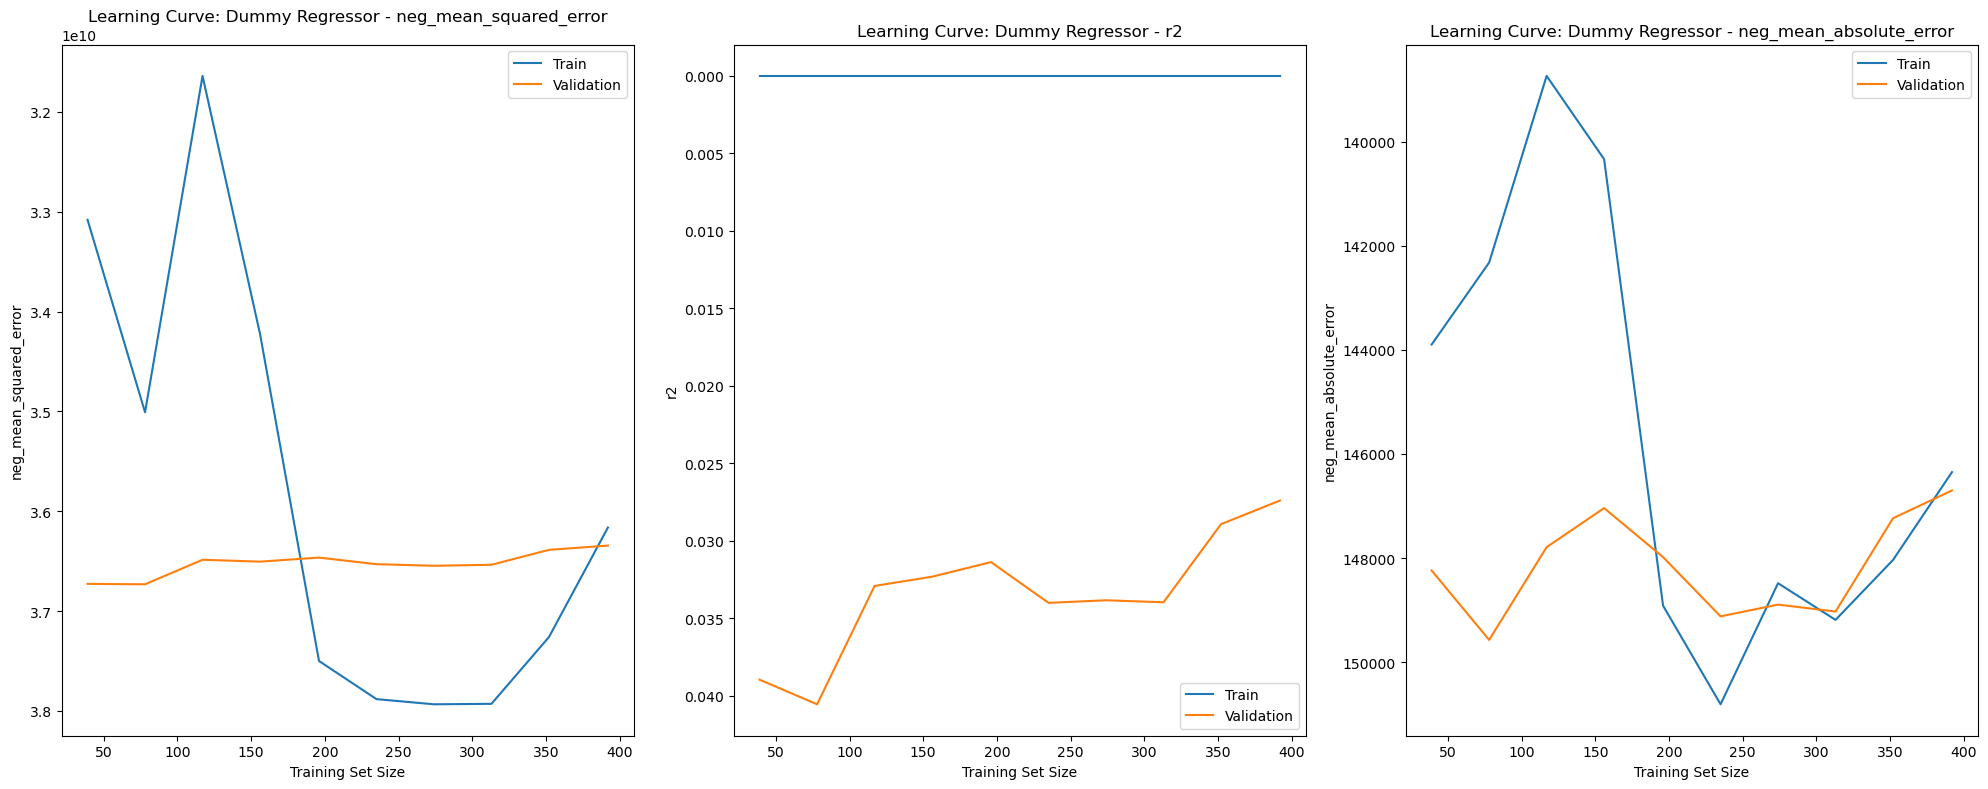

In [69]:
plot_learning_curve(DummyRegressor(), X_train, y_train, cv, scoring_metrics, train_sizes, steps,step,model_name="Dummy Regressor")

## Model Selection
__How did you select which learning algorithm to use?__

We will be using **Lasso** as the learning curves of Lasso and Linear regression models exhibit lower variance across all three scoring metrics (MSE, MAE, R2) compared to Ridge regression.The learning curves for MSE and MAE graphs of Lasso and Linear regression models show moderate bias, indicating that these models are able to capture the underlying patterns and relationships in the data fairly well without overfitting to it.

Why Lasso over Huber Regressor? Lasso has an inherent feature selection property. It performs automatic feature selection by shrinking the coefficients of irrelevant or less important features to zero as it applies L1 regularization.As there is no outliers for this dataset, Huber Regressor is not a great choice eventhough it is robust to outliers

### Can you say anything about the errors that the system makes?
- We can understand the errors of our models by creating a Prediction error plot and a Residual PLot
- We are goinng to compare our selected model to the baseline model

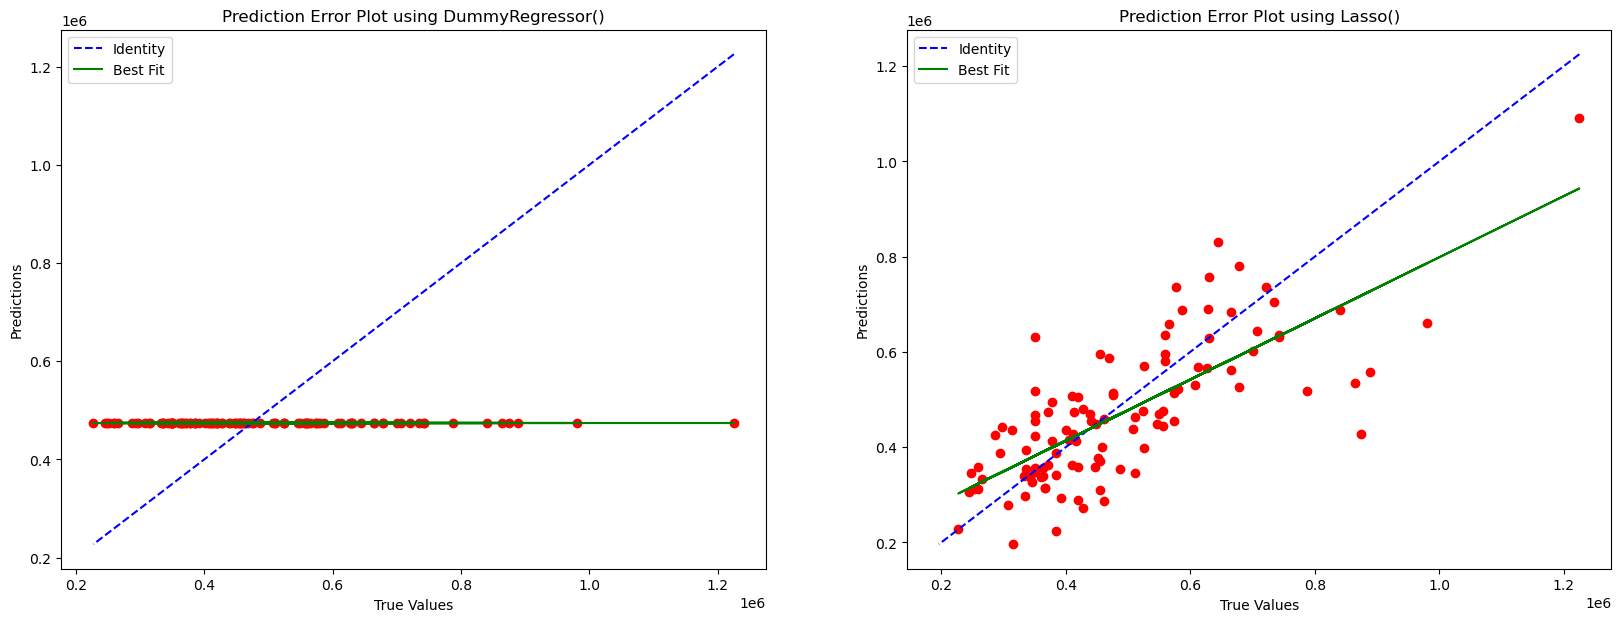

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plot_prediction_error_plot(DummyRegressor(), X_train,y_train,X_test, y_test, steps,step,ax1)
plot_prediction_error_plot(Lasso(), X_train,y_train,X_test, y_test,steps,step, ax2)
plt.show()

Observations:
 - The prediction error plot for Lasso suggests Homoscedasticity, which means that the residuals have consistent spread and do not systematically change with the magnitude of the true values.
 - However there are some outliers, where the model vastly under predicted the true values
 - Does not show any distinct patterns, as it could indicate systematic errors or issues with the model's ability to capture certain patterns in the data

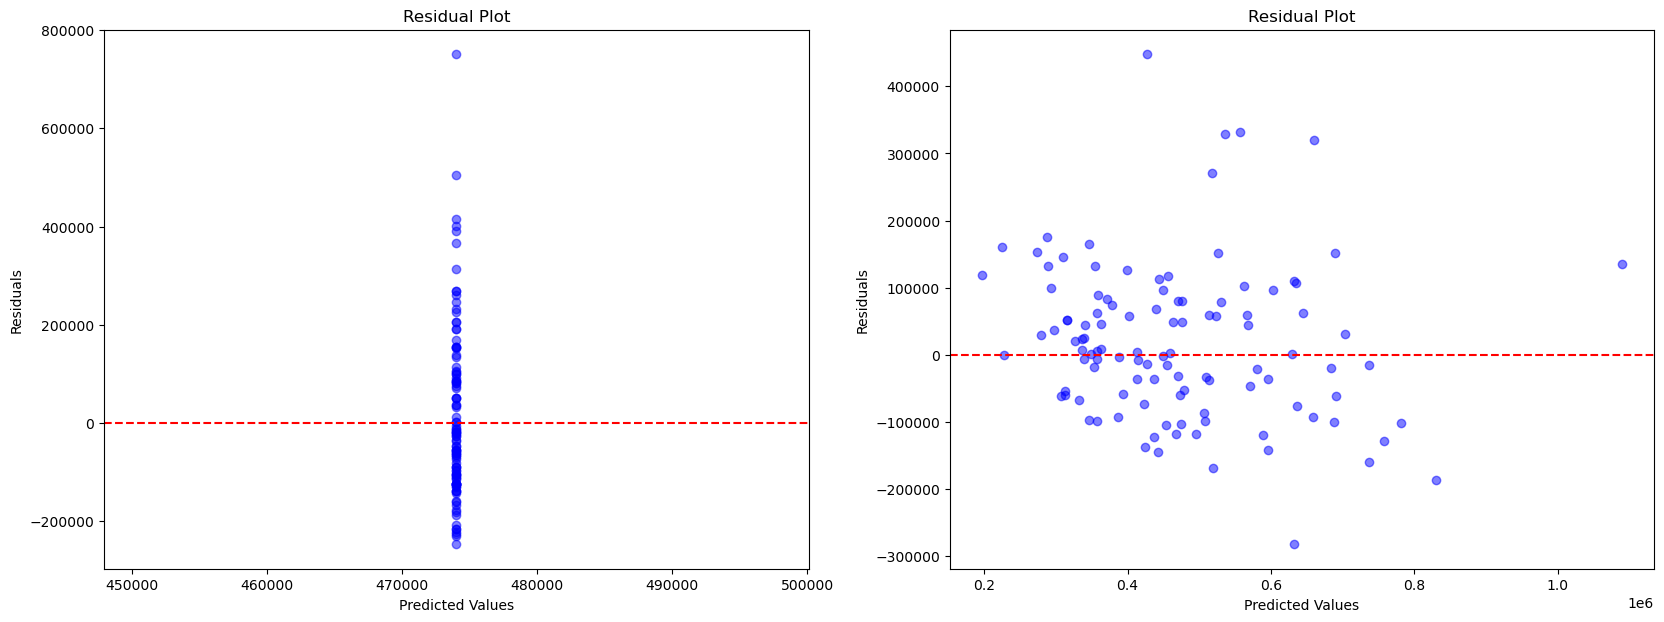

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plot_residuals(DummyRegressor(), X_train,y_train,X_test, y_test, steps,step,ax1)
plot_residuals(Lasso(), X_train,y_train,X_test, y_test, steps,step,ax2)
plt.show()

Observations:
 - The Residual plot shows Homoscedasticity, as all residuals have consistent spread
   - This suggests that the model's predictions are equally precise across the range of observed values.
 - However there are a few outliers at the top of the plot, this maybe because this is where the model performed poorly

## Model Improvements
- Hyperparameter Tuning
- Feature selection using Lasso

In [72]:
Lassoclassifier = Lasso()

print("KernelRidge Hyperparameters:")
for param_name in Lassoclassifier.get_params().keys():
    print(param_name)

KernelRidge Hyperparameters:
alpha
copy_X
fit_intercept
max_iter
positive
precompute
random_state
selection
tol
warm_start


In [81]:
X = transformed_df.drop(columns=['Price ($)'])
y = transformed_df['Price ($)']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, shuffle=True)
model = Lasso()

# Define the parameter grid to search over
param_grid = {
    'alpha': [30.0,40.0,50.0],
    'tol': [1e-2,1e-1,],
    'max_iter': [2000, 3000,4000],
    'selection': ['random', 'cyclic'],
    'fit_intercept': [False,True],
    'positive': [False,True],
    'precompute': [False,True],
    'random_state': [123, 456, 789],
}

# 'neg_mean_squared_error', 'neg_mean_absolute_error'
# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train2, y_train2)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

model_baseline = Lasso()
model_baseline.fit(X_train2, y_train2)
y_pred_baseline = model_baseline.predict(X_test2)

# Calculate the R2 score for the baseline model
r2_baseline = r2_score(y_test2, y_pred_baseline)

# Print the R2 score of the baseline model
print("R2 Score of Baseline Model:", r2_baseline)

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best R2 Score:", best_score)

R2 Score of Baseline Model: 0.6038165714376773
Best Parameters: {'alpha': 50.0, 'fit_intercept': True, 'max_iter': 2000, 'positive': False, 'precompute': True, 'random_state': 123, 'selection': 'cyclic', 'tol': 0.01}
Best R2 Score: 0.5093767944110958


We will be using R2 to base the GridsearchCV on
- With R2 being how well the model fits the data 

In [74]:
model_tuned = Lasso(**best_params)
model_not_tuned = Lasso()

scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
resultsdf = pd.DataFrame()

for name, model in [('LassoTuned', model_tuned), ('LassoNotTuned', model_not_tuned)]:
    cv_scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True)
    r2_train = np.mean(cv_scores['train_r2'])
    r2_test = np.mean(cv_scores['test_r2'])
    mse_train = np.mean(cv_scores['train_neg_mean_squared_error']) * -1
    mse_test = np.mean(cv_scores['test_neg_mean_squared_error']) * -1
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = np.mean(cv_scores['train_neg_mean_absolute_error']) * -1
    mae_test = np.mean(cv_scores['test_neg_mean_absolute_error']) * -1

    # Calculate MAPE directly without relying on 'estimator' key
    y_pred_train = cross_val_predict(model, X_train, y_train, cv=cv)
    mape_train = round(np.mean(np.abs(y_train - y_pred_train) / y_train) * 100, 2)
    y_pred_test = model.fit(X_train, y_train).predict(X_test)
    mape_test = round(np.mean(np.abs(y_test - y_pred_test) / y_test) * 100, 2)

    model_scores = pd.Series({'Model': name, 'R-squared (Train)': r2_train, 'R-squared (Test)': r2_test,
                              'RMSE (Train)': rmse_train, 'RMSE (Test)': rmse_test,
                              'MAPE (Train)': mape_train, 'MAPE (Test)': mape_test})
    resultsdf = resultsdf.append(model_scores, ignore_index=True)

display(resultsdf)

,Model,R-squared (Train),R-squared (Test),RMSE (Train),RMSE (Test),MAPE (Train),MAPE (Test)
0,LassoTuned,0.513771,0.457361,132515.047298,135638.077915,22.43,19.35
1,LassoNotTuned,0.556464,0.505970,126568.402324,129944.855270,21.17,17.39


Observations:
 -  Our model which is already tuned does not show any significant increase in its R2 and RMSE, while even slighty deproving for MAPE
    - This maybe because the model is already performing close to its optimal capacity and hyperparameter tuning may have limited impact
    - The default hyperparameter values may already be well-suited for the problem at hand which we can see from the learning curves of Lasso showing moderate bias and variance, tuning may have limited impact.

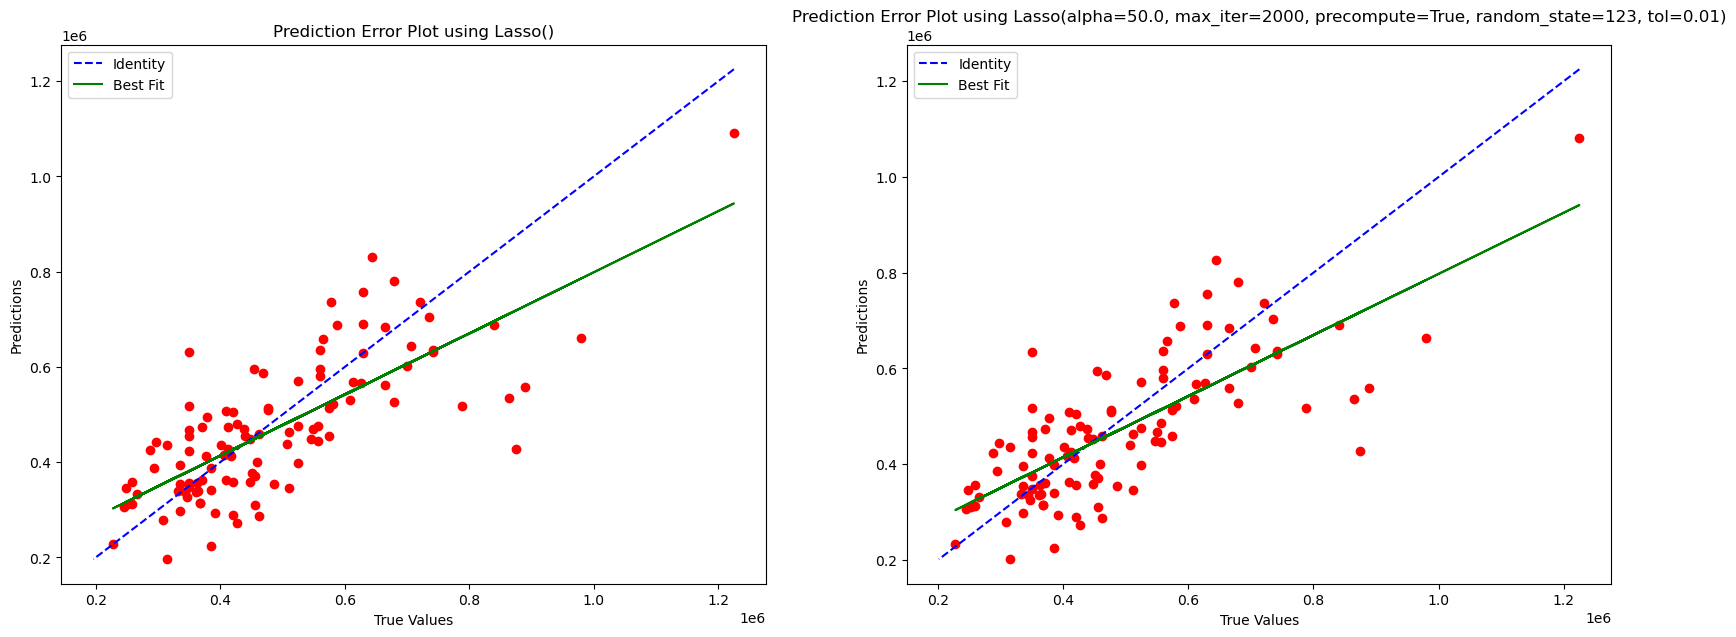

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plot_prediction_error_plot(Lasso(), X_train,y_train,X_test, y_test, steps,step,ax1)
plot_prediction_error_plot(Lasso(**best_params), X_train,y_train,X_test, y_test, steps,step,ax2)
plt.show()

As expected, we do not see any significate changes to the Prediction Error plot

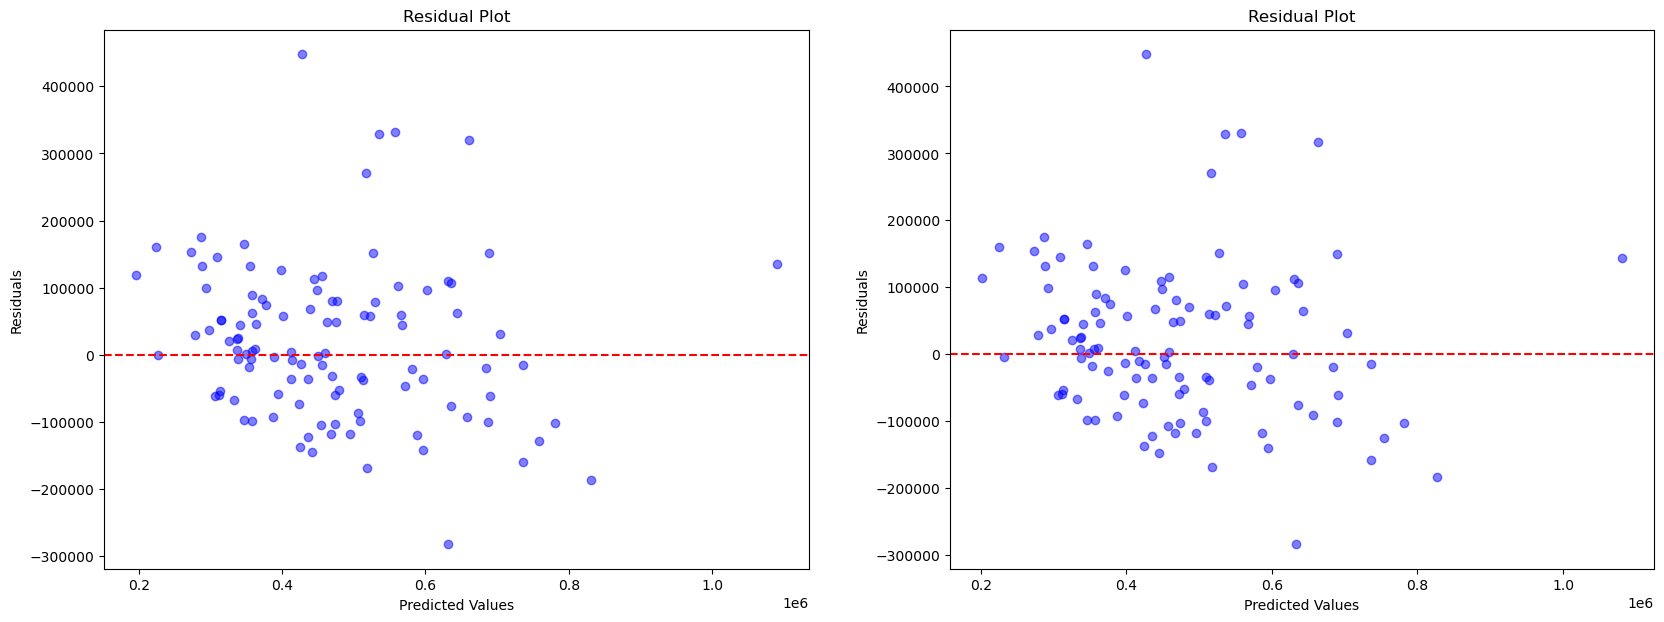

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plot_residuals(Lasso(), X_train,y_train,X_test, y_test,steps ,step,ax1)
plot_residuals(Lasso(**best_params), X_train,y_train,X_test, y_test, steps,step,ax2)
plt.show()

We can also see not that much of a difference between tuned and untuned residual plots

### Feature Importance

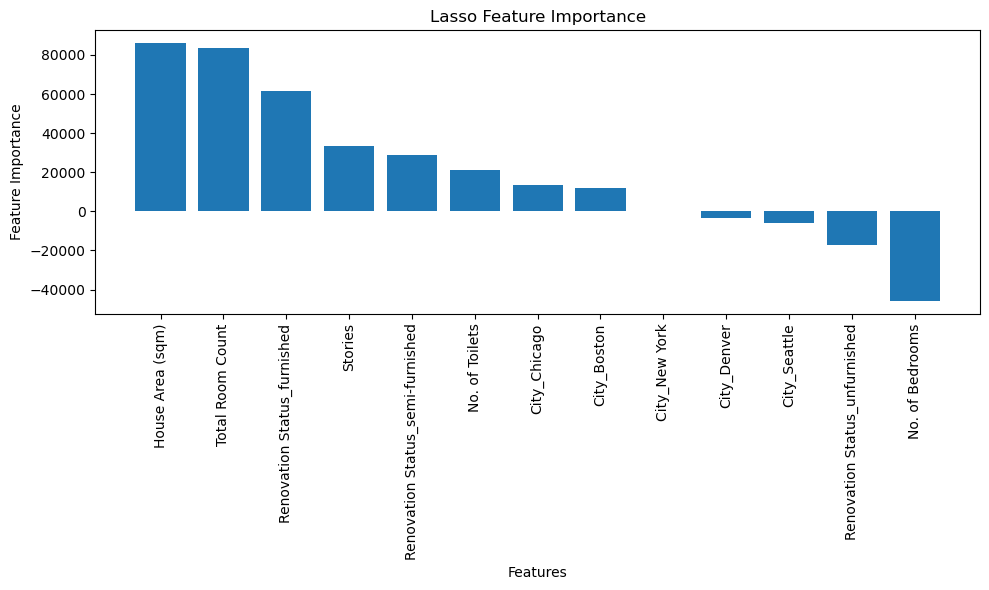

In [77]:
lasso_model = Lasso()
lasso_model.fit(X_train2, y_train2)

# Retrieve the feature importance (coefficients) from the Lasso model
feature_importance = lasso_model.coef_

# Sort the feature importance in descending order
sorted_indices = feature_importance.argsort()[::-1]
sorted_importance = feature_importance[sorted_indices]
sorted_features = X.columns[sorted_indices]

# Plot the sorted feature importance using a bar graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(sorted_importance)), sorted_importance)
ax.set_xticks(range(len(sorted_importance)))
ax.set_xticklabels(sorted_features, rotation=90)
ax.set_xlabel("Features")
ax.set_ylabel("Feature Importance")
ax.set_title("Lasso Feature Importance")
plt.tight_layout()
plt.show()



Observations:
- House Area and Total Room Count(semi-furnished) has the higest magnitude of the various features indicating a stronger influence of the features on the target variable.
- While City(New York) has the lowest magnitude, being close to 0 showing that this feature has a weak or negligible impact on the predictions made by the Lasso model
  - Generally the City feature does not have a major impact on the model, this can be explained by cities not drastically differing in price

### Saving Model
We will be using the pickle library to save the model

In [78]:
model_final = Lasso(**best_params)
pickle.dump(model_final, open("Lasso.p", "wb"))
Lasso_regression = pickle.load(open("Lasso.p", "rb"))

### Final Model Evaulation
**How do you evaluate the quality of your system?**

- We will be testing our tuned model against unseen data

In [79]:
final = Pipeline([
    ('preprocessing', preprocessor),
    ('Model', Lasso(**best_params))
])

In [80]:
final.fit(X_train, y_train) 

y_pred = final.predict(X_test)
y_pred_train = final.predict(X_train)
mae_scores, mape_scores, rmse_scores, r2 = [], [], [], []
for (prediction, actual) in ((y_pred, y_test), (y_pred_train, y_train)):
  mae_scores.append(mean_absolute_error(actual, prediction))
  mape_scores.append(mean_absolute_percentage_error(actual, prediction))
  rmse_scores.append(np.sqrt(mean_squared_error(actual, prediction)))
  r2 = r2_score(actual, prediction)
  

final_scores = pd.DataFrame({
    "MAE" : mae_scores,
    "MAPE" : mape_scores,
    "RMSE" : rmse_scores,
    "R Squared" : r2
}, index=["Test", "Train"])
display(final_scores)

,MAE,MAPE,RMSE,R Squared
Test,490968.032076,1.084047,504254.979922,-5.663265
Train,474033.128440,1.091316,490712.933491,-5.663265


## Conclusion
We have successfully created a model that is able to predict the Housing Price in the US. Through extensive feature engineering, we have develop a simple model that is able to predict the Housing Price in the US. However, the model still faces some limitations. It has only been trained and tested on a small amount of features, there are likely other significant factors that can affect housing prices, such as lease duration and location factors like proximity to amenities, transportation, and schools. For the model to be fully deployed, it is necessary to collect more data and test it on real life examples through the use of gathering demographic and economic data, and incorporating external datasets.